In [107]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

np.random.seed(0)

In [108]:
df = pd.read_csv("/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [109]:
df.isna().sum()

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


Need to fix the date column in order for dates to be read as dates instead of a string

In [111]:
# Removing old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop = True)
# removing columns with mostly missing values/ Nan
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis = 1)

In [112]:
# Simple column names 
df.columns = ['date', 'rainfall','depth_to_groundwater','temperature','drainage_volume','river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [113]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset = ['date'], **{'background-color' : 'skyblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## Data Visualization

- **`Rainfall`**: indicates the quantity of rainfall in (mm)
- **`Temperature`**: indicates the tempreature (C)
- **`Volume`**: indicates the volume of water taken from drinking water treatment plant (m^3)
- **`Depth to Groundwater`**: indicates the groundwater level (meters from the ground floor)

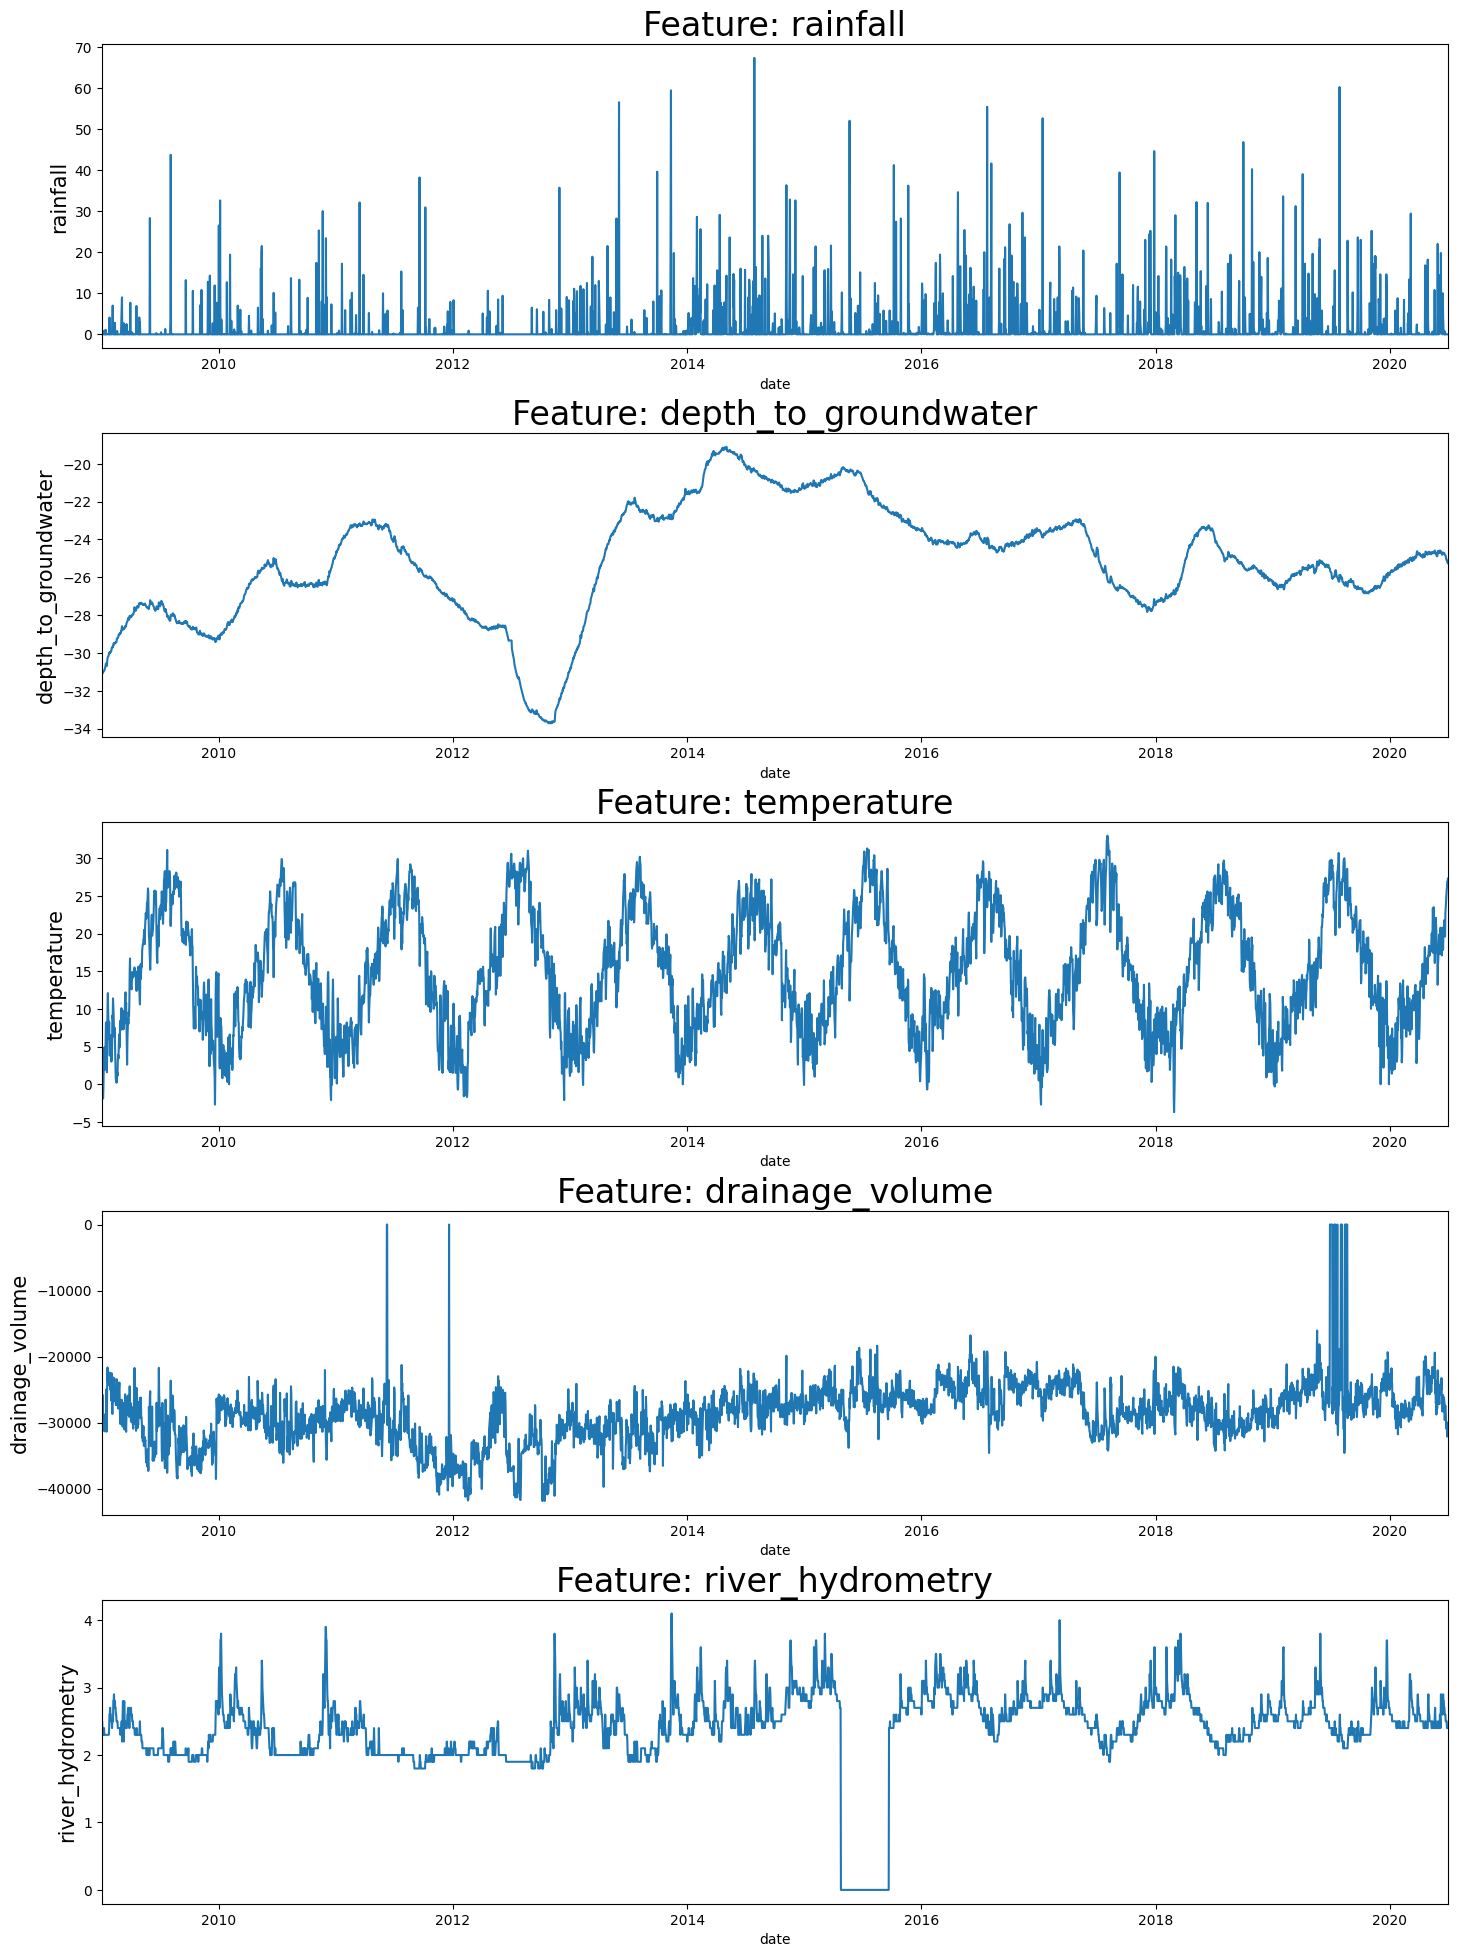

In [114]:
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(15,20))
plt.tight_layout(pad = 4)

for i,column in enumerate(df.drop('date', axis = 1).columns):
    sns.lineplot(x=df['date'], y = df[column].fillna(method = 'ffill'), ax = ax[i])
    ax[i].set_title(f"Feature: {column}", fontsize = 24)
    ax[i].set_ylabel(ylabel = column, fontsize = 15)
    ax[i].set_xlim([date(2009,1,1), date(2020,6,30)])

## Data PreProcessing

### Chronological order and equidistant timestamps 

need to have the data in chronological order by sorting `df` by `date`. Having equidistant timestamps indicates constant time intervals, can do this by taking a difference between timestamps or set a constant time interval and resample the dates. 

In [115]:
df = df.sort_values(by='date')
# check time intervals 
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [116]:
df['delta'].sum() ,df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

### Handling missing values

Some of the missing values and some missing that are zeros. cleaning by replacing the nan values and filling them

In [117]:
df = df.drop('delta', axis = 1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

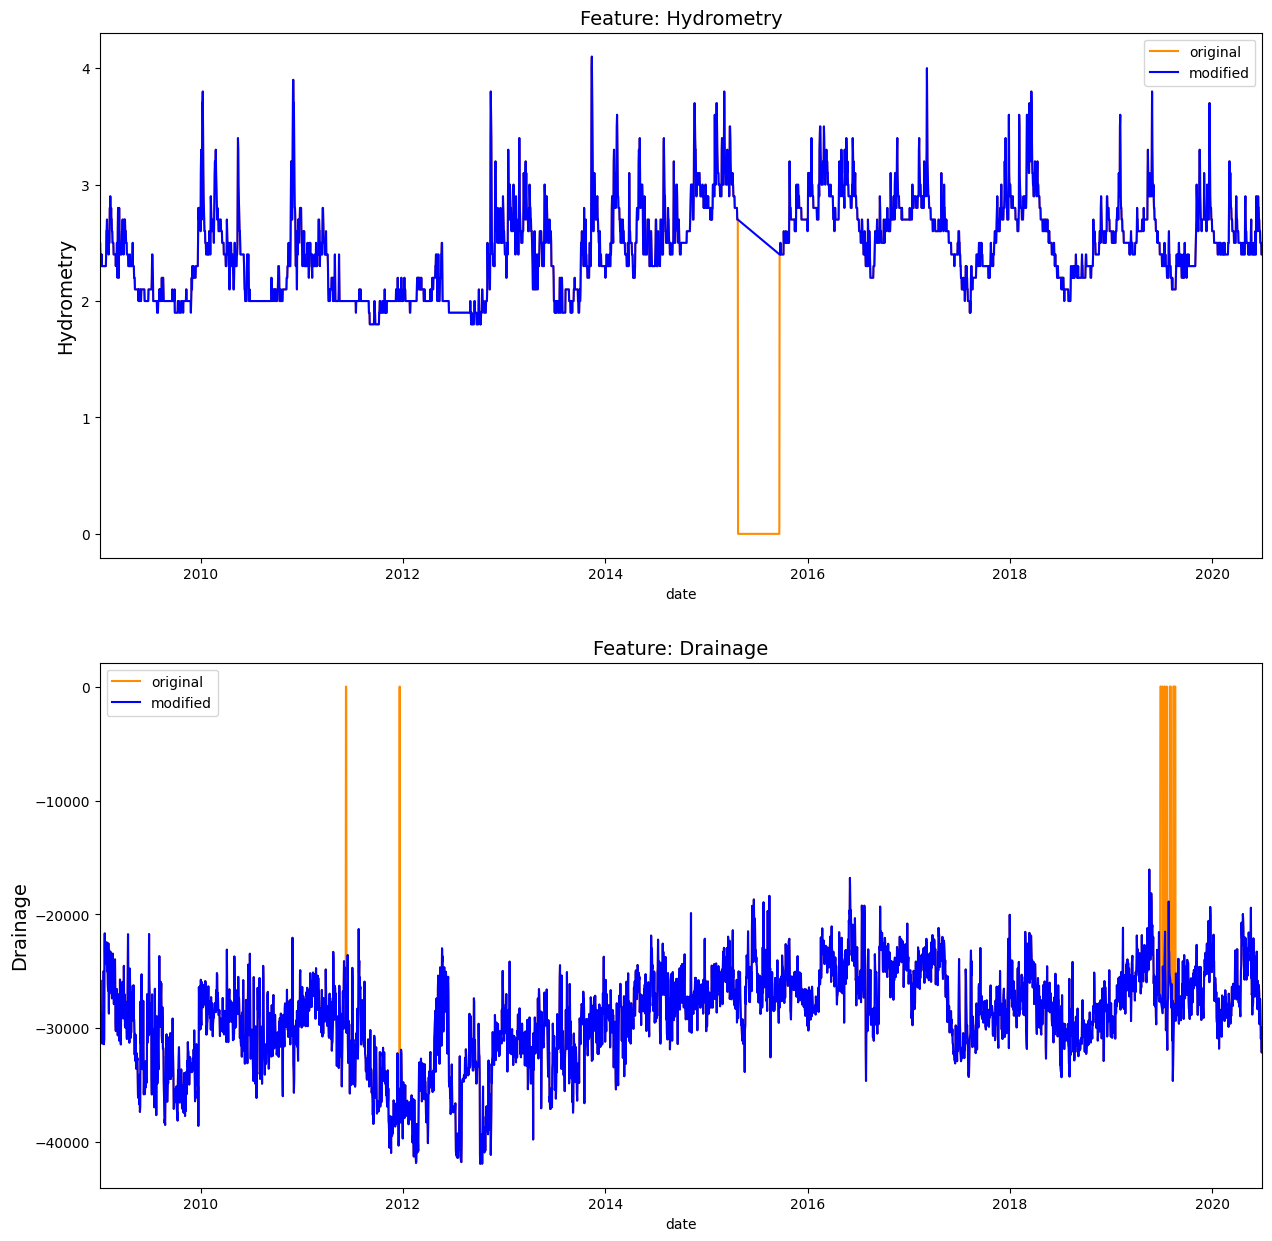

In [118]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(15,15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y = old_hydrometry, 
             ax = axs[0], color = 'darkorange', 
             label = 'original')
sns.lineplot(x=df['date'], y = df['river_hydrometry'].fillna(np.inf), ax = axs[0], color = 'blue', label = 'modified')
axs[0].set_title("Feature: Hydrometry", fontsize = 14)
axs[0].set_ylabel(ylabel = "Hydrometry", fontsize = 14)
axs[0].set_xlim([date(2009,1,1), date(2020,6,30) ])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y = old_drainage, ax=axs[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=axs[1], color='blue', label='modified')
axs[1].set_title("Feature: Drainage", fontsize=14)
axs[1].set_ylabel(ylabel="Drainage", fontsize=14)
axs[1].set_xlim([date(2009,1,1), date(2020,6,30)])

/tmp/ipykernel_33/2019522658.py:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


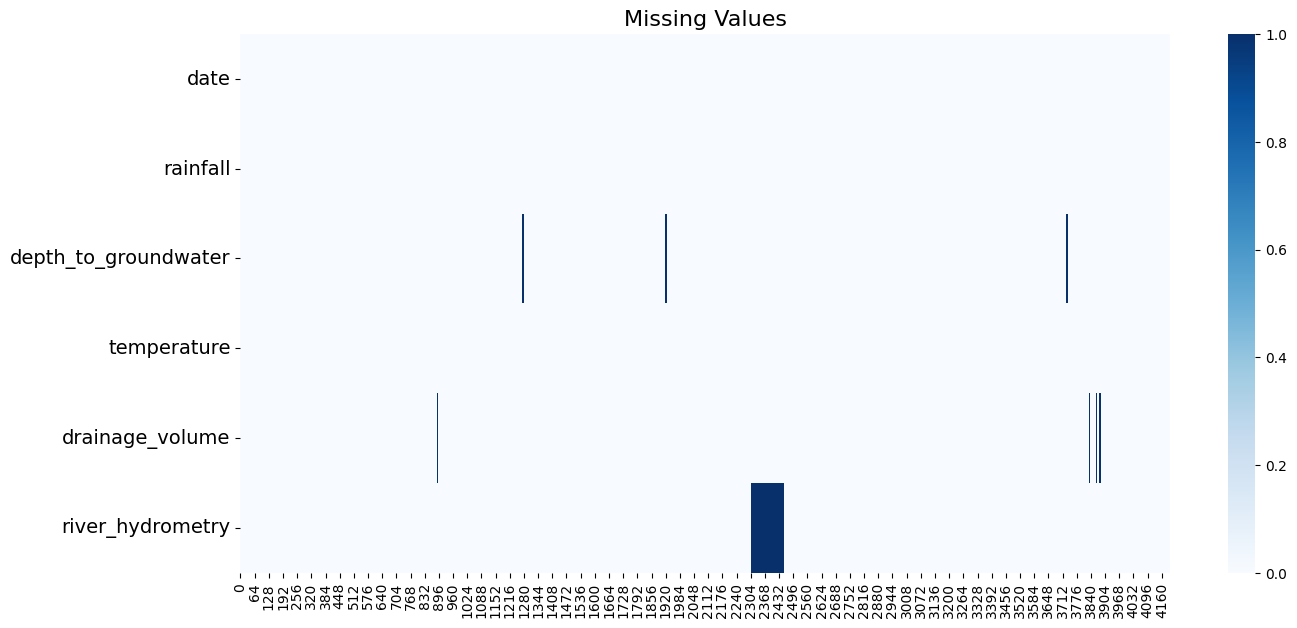

In [119]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))

sns.heatmap(df.T.isna(), cmap = 'Blues')
axs.set_title("Missing Values", fontsize=16)

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

### Methods for hanglins missing values
1. Fill Nan with outliers or Zero:
    filling missing values like this may seem worse but often results in better modeling 

2. Fill Nan with Mean values
    May not always result in a good model

3. Fill Nan with the last value using .ffill()
    May have good results 
    
4. Fill Nan with linearly interpolated value with .interpolate()
    Might be the best option depending on the data but requires knowledge of neighboring values 

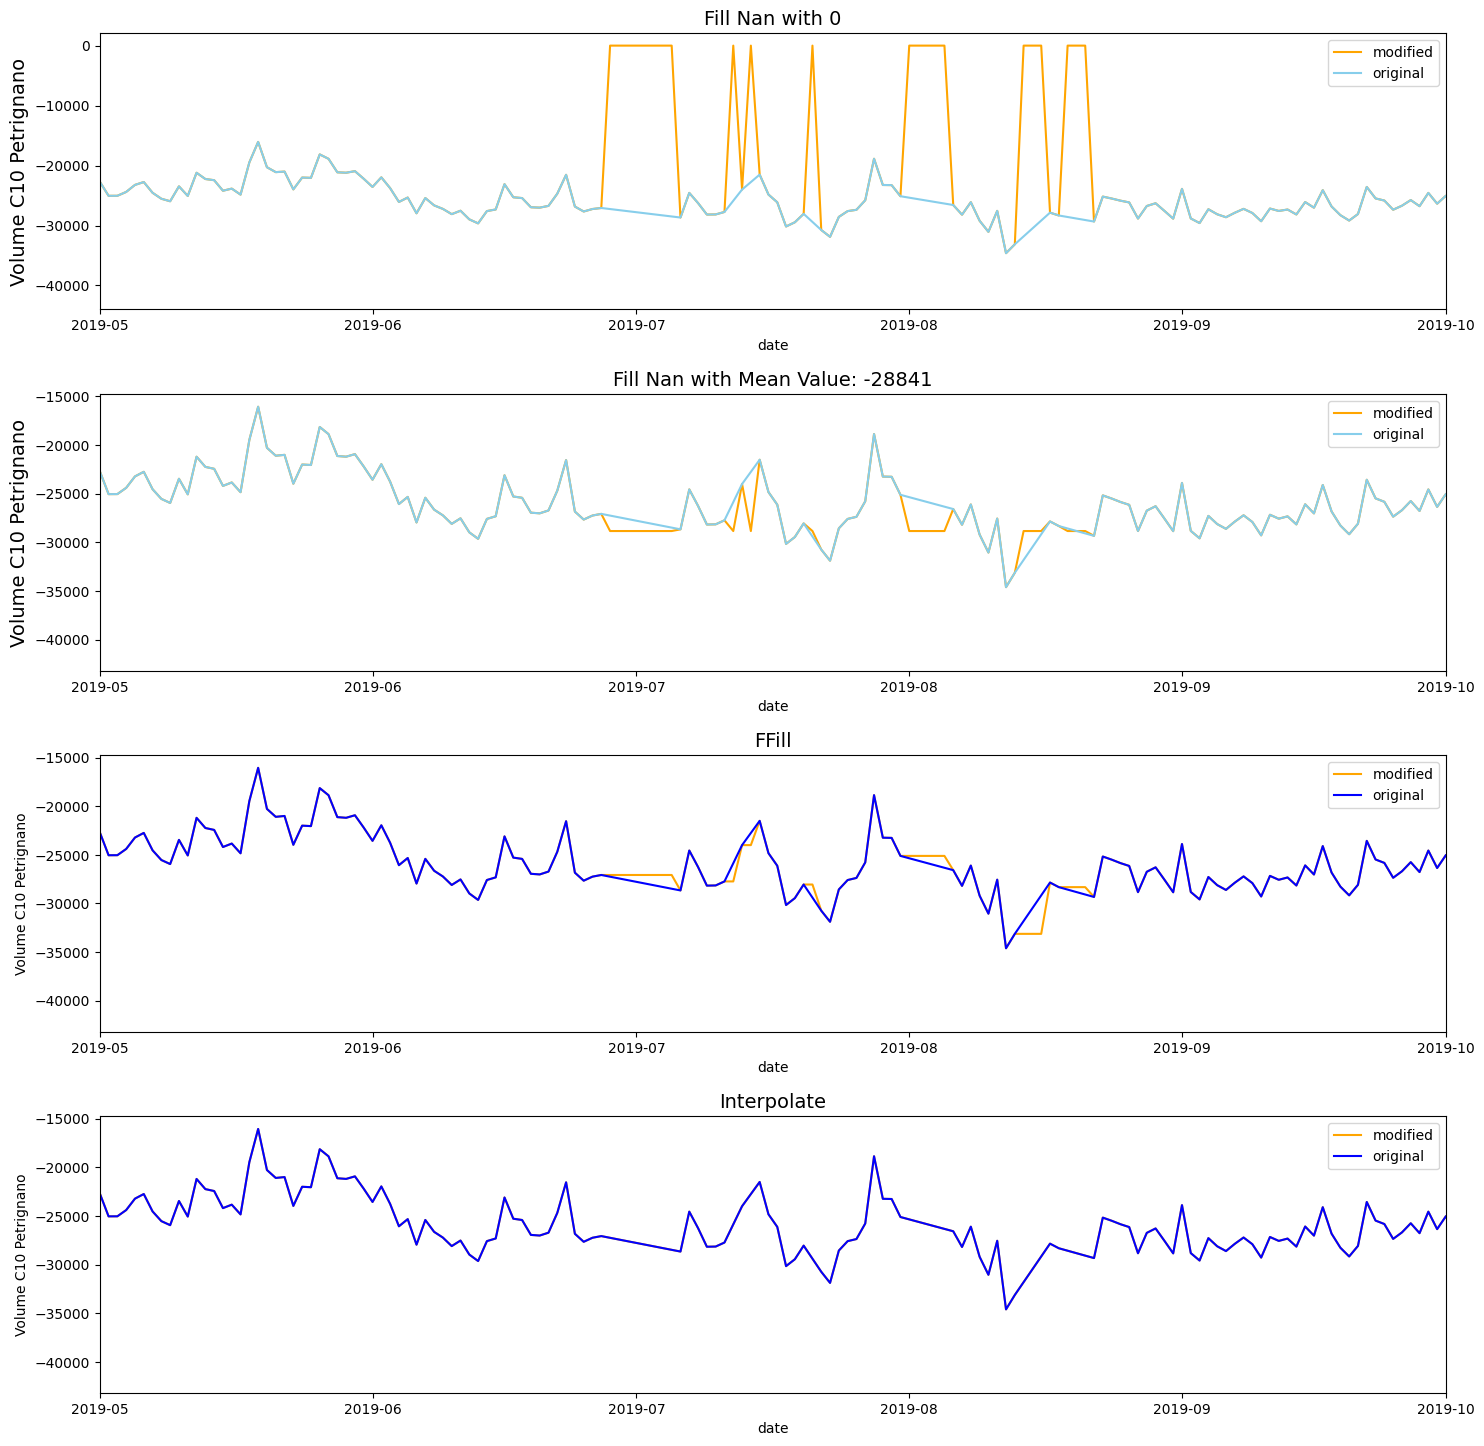

In [120]:
fig, axs = plt.subplots(4, 1, figsize=(15,15))
plt.tight_layout(pad = 4)

sns.lineplot(x=df['date'], y = df['drainage_volume'].fillna(0), ax = axs[0], color='orange', label = 'modified')
sns.lineplot(x=df['date'], y = df['drainage_volume'].fillna(np.inf), ax = axs[0], color = 'skyblue', label = 'original')
axs[0].set_title("Fill Nan with 0", fontsize = 14)
axs[0].set_ylabel(ylabel="Volume C10 Petrignano", fontsize = 14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax = axs[1], color='orange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax = axs[1], color = 'skyblue', label = 'original')
axs[1].set_title(f"Fill Nan with Mean Value: {mean_drainage:.0f}", fontsize = 14)
axs[1].set_ylabel(ylabel="Volume C10 Petrignano", fontsize = 14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax = axs[2], color = 'orange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=axs[2], color = 'blue', label = 'original')
axs[2].set_title("FFill", fontsize = 14)
axs[2].set_ylabel(ylabel="Volume C10 Petrignano")

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax = axs[3], color = 'orange', label = 'modified')
sns.lineplot(x=df['date'], y =df['drainage_volume'].fillna(np.inf), ax = axs[3], color = 'blue', label = 'original')
axs[3].set_title("Interpolate", fontsize = 14)
axs[3].set_ylabel(ylabel="Volume C10 Petrignano")

for i in range(4):
    axs[i].set_xlim([date(2019,5,1), date(2019,10,1)])


In [121]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

### Smoothing data / Resampling 

2 types of resampling:
1. **Upsampling**: when the frequency of samples is increased (e.g. days to hours)
2. **Downsampling**: when the frequency of samples is decreased (days to weeks)

will do some downsampling with the `.resample()` function (similar to `groupby` and aggregate as mean).

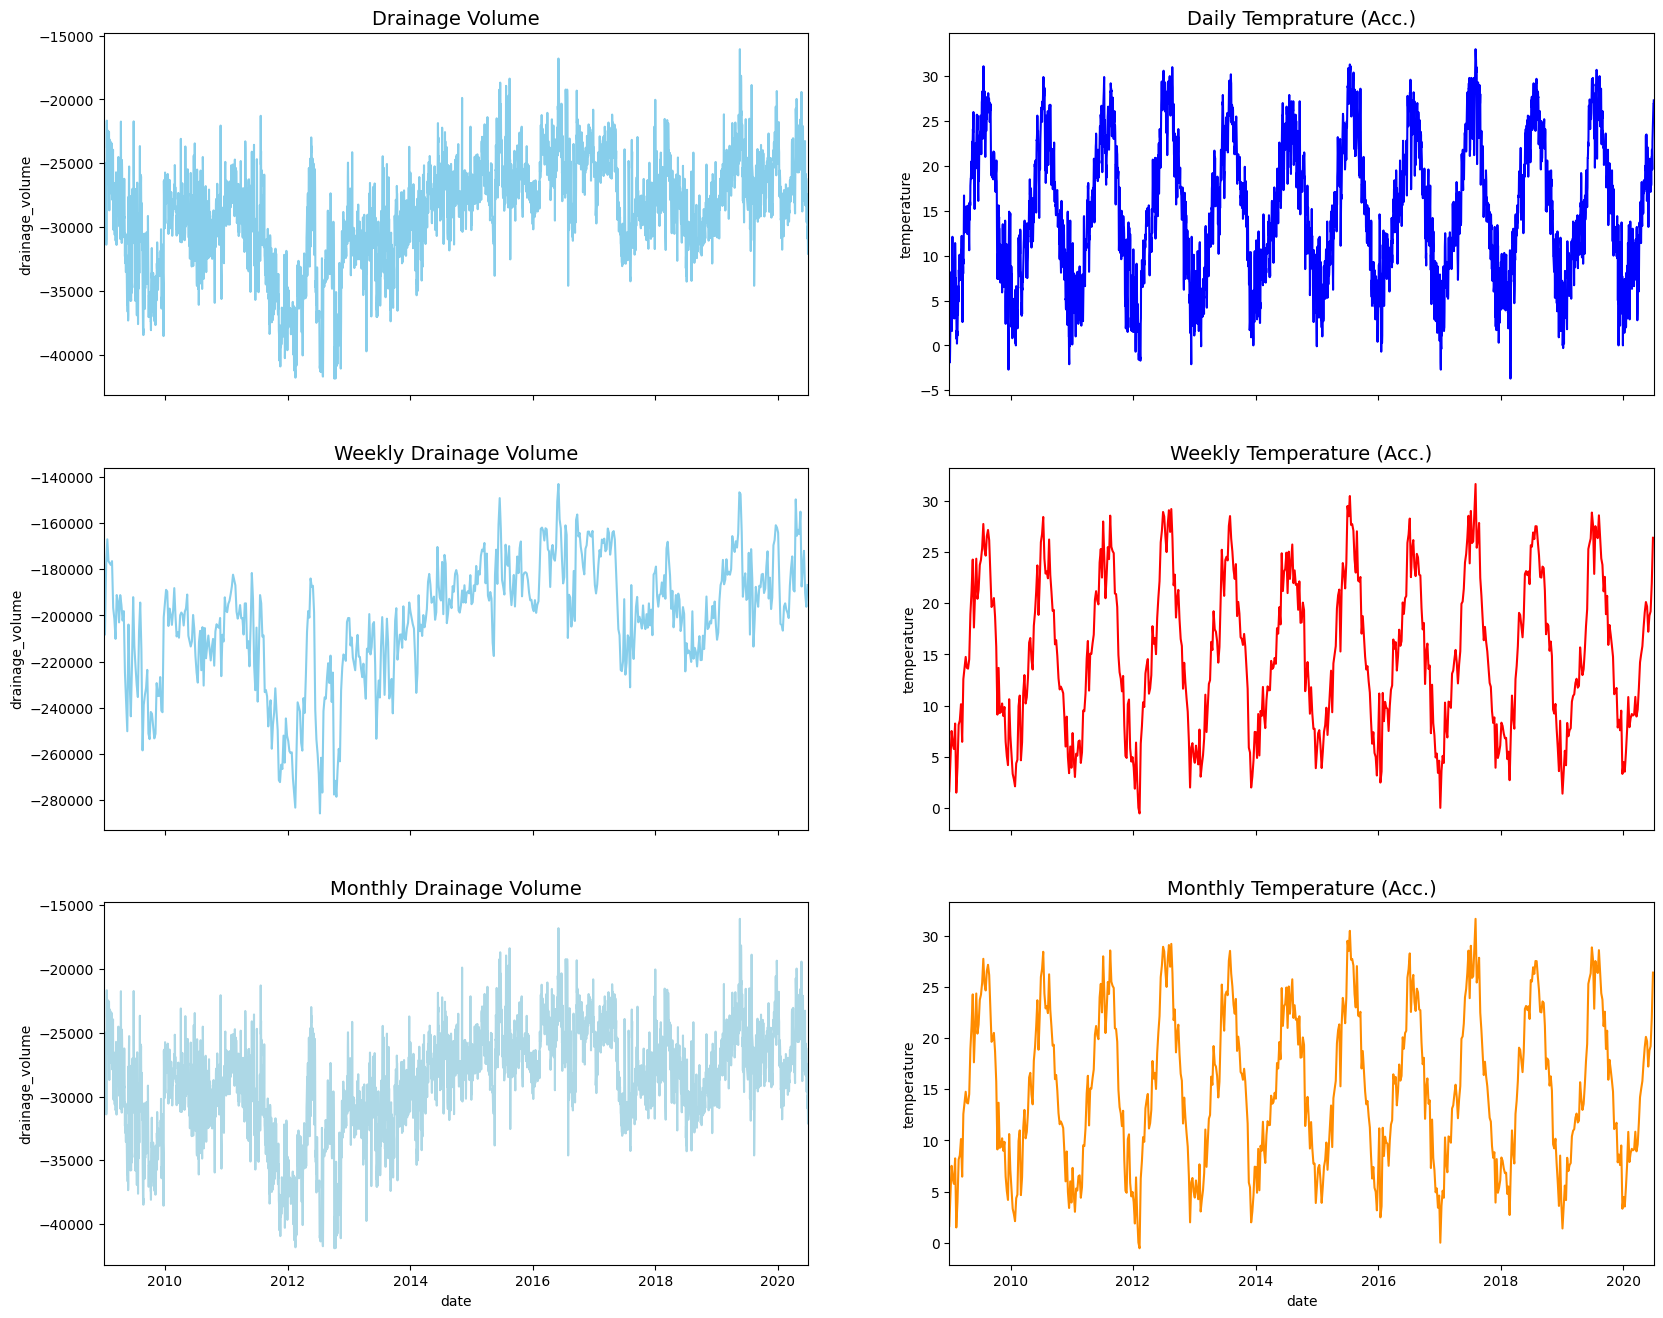

In [122]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, sharex=True, figsize=(20,16))

sns.lineplot(x = df['date'], y = df['drainage_volume'], color = 'skyblue', ax = axs[0,0])
axs[0,0].set_title("Drainage Volume", fontsize = 14)

resampled_df = df[['date','drainage_volume']].resample('7D', on = 'date').sum().reset_index(drop = False)
sns.lineplot(x = resampled_df['date'], y = resampled_df['drainage_volume'], color = 'skyblue', ax = axs[1,0])
axs[1,0].set_title("Weekly Drainage Volume", fontsize = 14)

resampled_df = df[['date','drainage_volume']].resample('M', on = 'date').sum().reset_index(drop = False)
sns.lineplot(x = df['date'], y = df['drainage_volume'], color = 'lightblue', ax = axs[2,0])
axs[2,0].set_title("Monthly Drainage Volume", fontsize = 14)

for i in range(3):
    axs[i,0].set_xlim([date(2009,1,1), date(2020,6,30)])
    
sns.lineplot(x = df['date'], y = df['temperature'], color = 'blue', ax = axs[0,1])
axs[0,1].set_title("Daily Temprature (Acc.)", fontsize = 14)

resampled_df = df[['date', 'temperature']].resample("7D", on = 'date').mean().reset_index(drop = False)
sns.lineplot(x = resampled_df['date'], y = resampled_df['temperature'], color = 'red', ax = axs[1,1])
axs[1,1].set_title("Weekly Temperature (Acc.)", fontsize = 14)

resampled_Df = df[['date', 'temperature']].resample("M", on='date').mean().reset_index(drop=False)
sns.lineplot(x = resampled_df['date'], y=resampled_df['temperature'], color = 'darkorange', ax = axs[2,1])
axs[2,1].set_title("Monthly Temperature (Acc.)", fontsize = 14)

for i in range(3):
    axs[i,1].set_xlim([date(2009,1,1),date(2020,6,30)])

plt.show()

Weekly downsampling helps smooth the data and is easier for modeling 

In [123]:
downsample = df[['date',
                'depth_to_groundwater',
                'temperature',
                'drainage_volume',
                'river_hydrometry',
                'rainfall']].resample("7D", on='date').mean().reset_index(drop = False)

df = downsample.copy()

The check for stationarity can be done with the 3 methods below:

1. **Visuall**: plot time series and check for trends or seasonality
2. **Basic Statistics**: split time series and compare the mean and variance of each partition
3. **Statistical Test**: Augmented Dickey Fuller Test


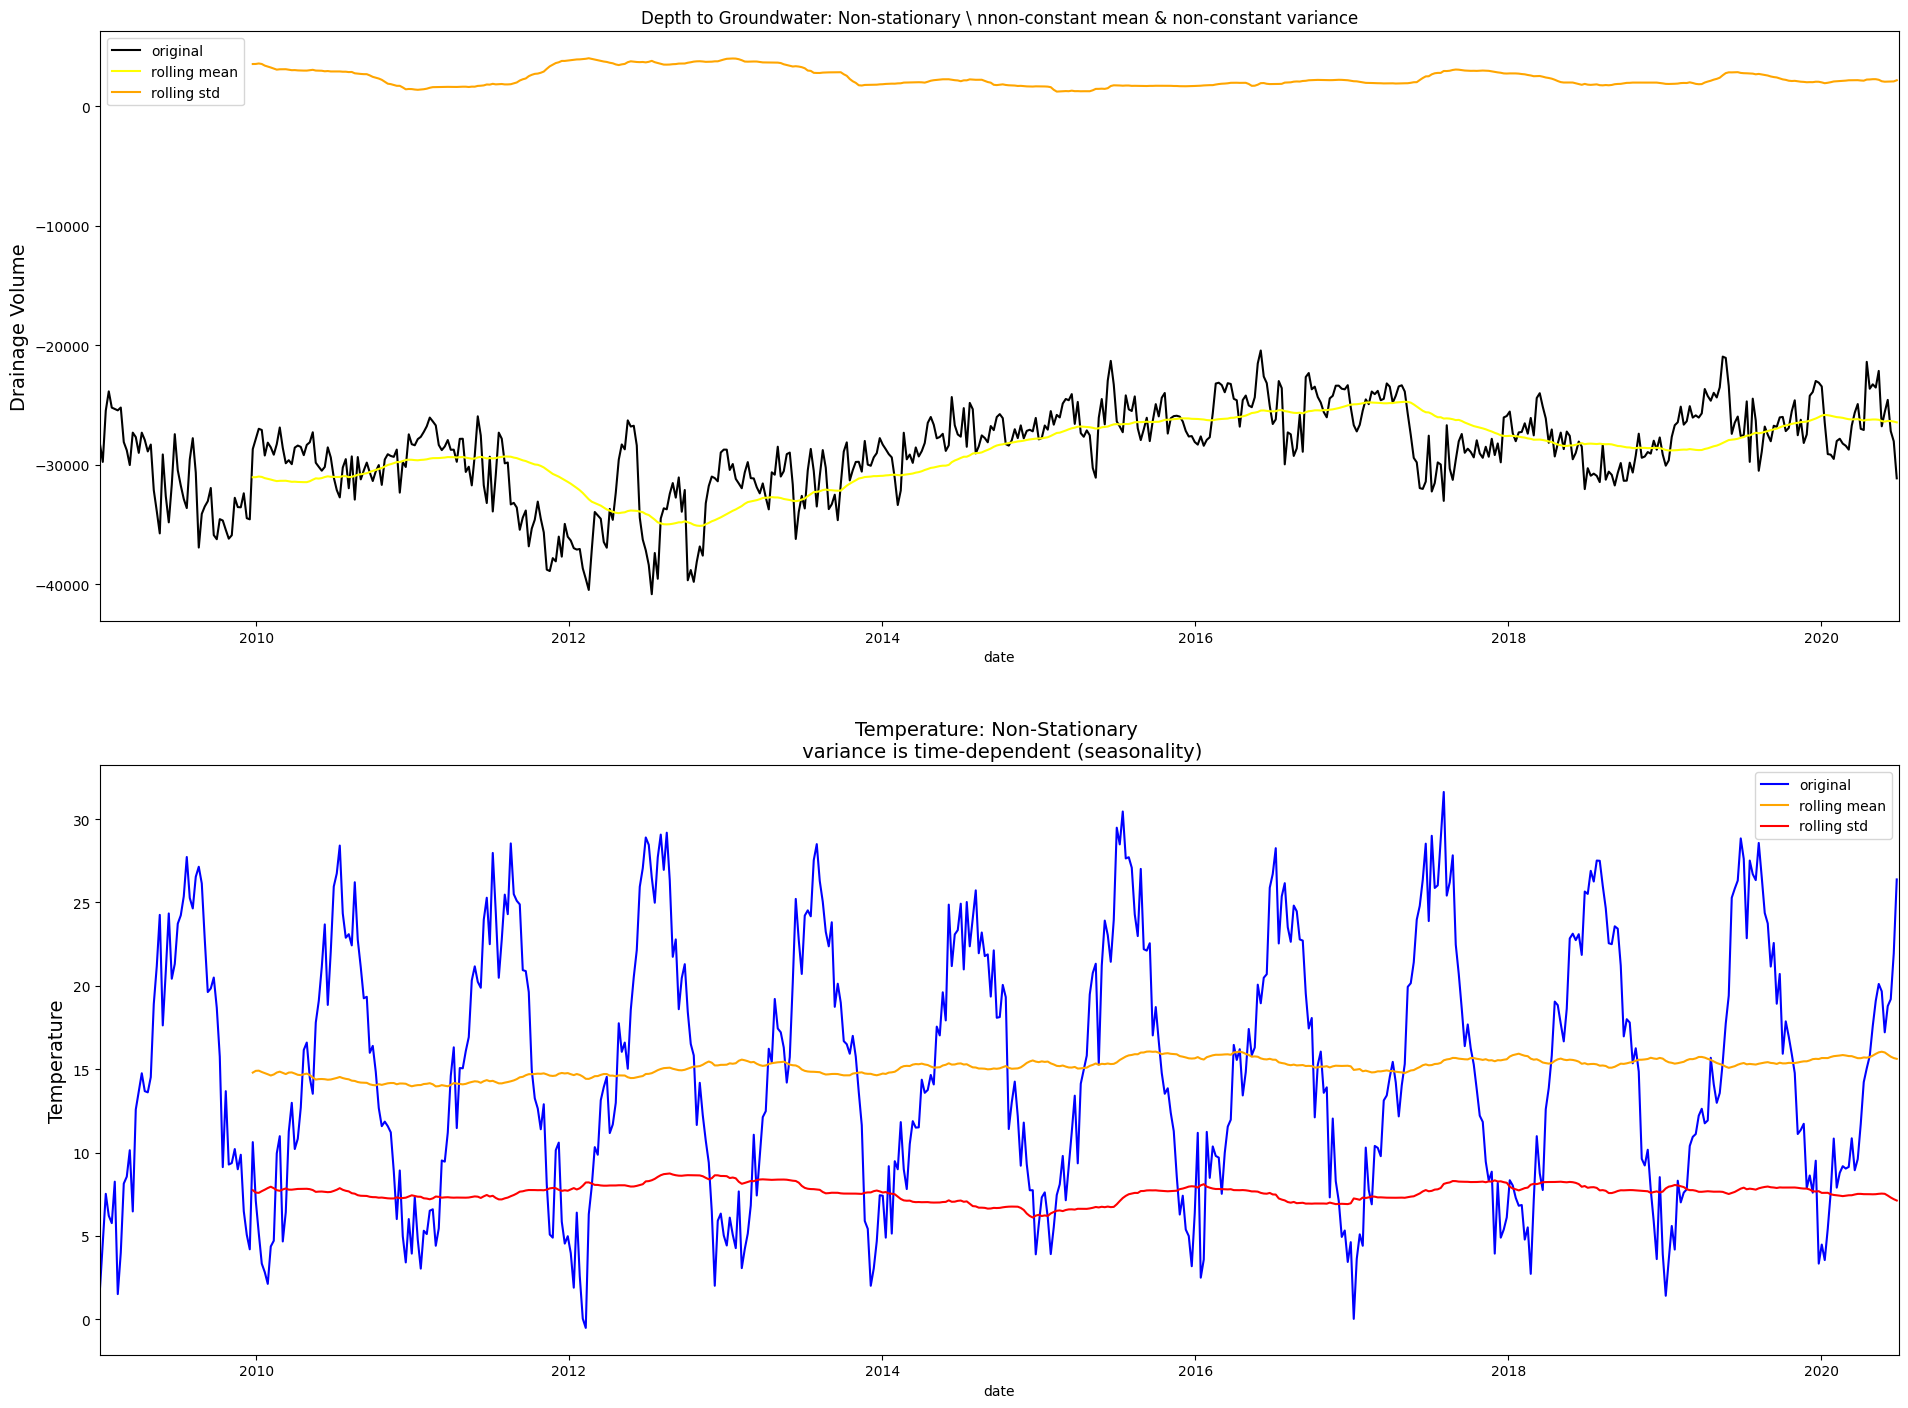

In [124]:
rolling_window = 52

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20,15))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax = axs[0], color = 'black', label = 'original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean() , ax = axs[0], color = 'yellow', label = 'rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std() , ax = axs[0] , color = 'orange' , label = 'rolling std')
axs[0].set_title("Depth to Groundwater: Non-stationary \ nnon-constant mean & non-constant variance", )
axs[0].set_ylabel(ylabel="Drainage Volume", fontsize= 14)
axs[0].set_xlim([date(2009,1,1), date(2020,6,30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax = axs[1], color = 'blue', label = 'original')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax = axs[1], color = 'orange', label = 'rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax = axs[1], color = 'red', label = 'rolling std')
axs[1].set_title("Temperature: Non-Stationary \n variance is time-dependent (seasonality)", fontsize = 14)
axs[1].set_ylabel(ylabel="Temperature", fontsize = 14)
axs[1].set_xlim([date(2009,1,1), date(2020,6,30)])

plt.tight_layout(pad = 4)
plt.show()

### Unit Root Test

Unit Root is a characteristic of a time series that makes it non-stationary.

$Y_t = \alpha Y_{t-1} + \beta X_{e} + \epsilon $

$Y_t$ is the value of time series at a time `t` and $X_e$ is an exogenous variable.

The presence of a unit root means that the time series is non-stationary.

**Augmented Dickey-Fuller (ADF)**: is a type of statistical test called a unit root test. Unit roots are a cause for non-stationary.
- **Null Hypothesis $(H_0)$:** Time series has a unit root. (Time series is not stationary).
- **Alternate Hypothesis $(H_1)$:** Time series has no unit root ( Time series is stationary).



2 ways to reject the null hypothesis

On one hand, null hypothesis can be rejected if the value if below a set significant level. (default is 5%).

- **p-value > significance level (default: 0.05):** Fail to reject $H_0$ -> is non-stationary.
- **p-value <= significance level (default: 0.05):** Reject the null hypothesis -> Stationary

If ADF is less than the critical value:
- **ADF Statistic > critical value:** fail to reject $H_0$ -> non-stationary
- **ADF Statistic < critical value:** Reject the $H_0$ -> Stationary

In [125]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166605,
 0.047699190920208856,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

Check for each feature:
- p-value is less than 0.05
- checking the range of the ADF statistic compared with critical_values

In [126]:
def visualize_adfuller_results(series, title, axs):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & ((adf_stat < crit_val_5)):
        linecolor = 'orange'
    elif (p_val < significance_level) & ((adf_stat < critical_val_10)):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y= series, ax = axs, color = linecolor)
    axs.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f} \n Critical Value 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize = 14)
    axs.set_ylabel(ylabel=title, fontsize = 14)

In [127]:
t=adfuller(df['rainfall'].values)

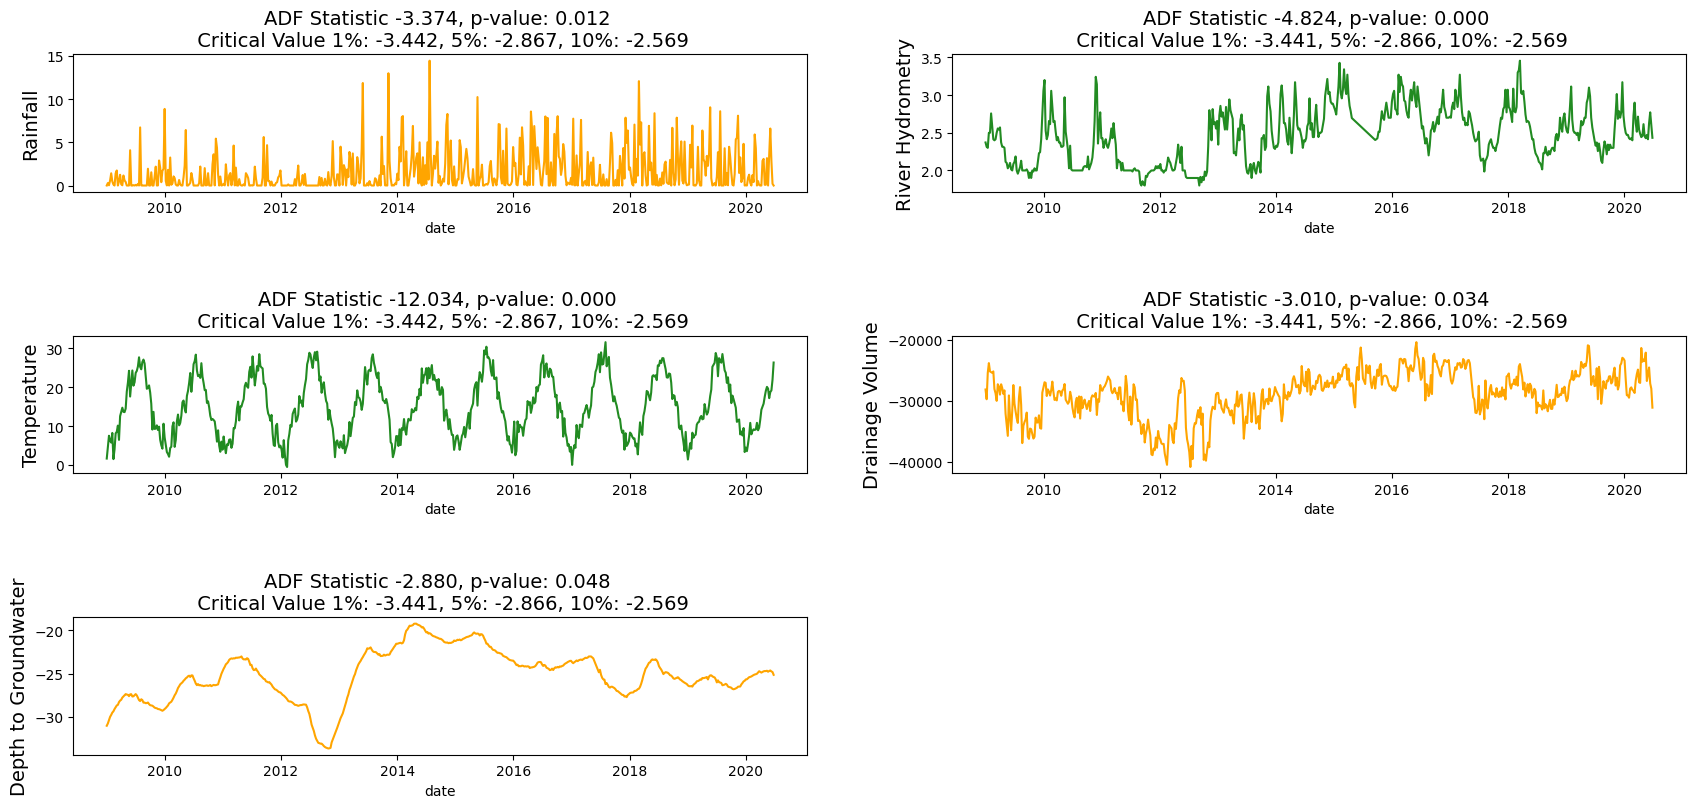

In [128]:
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize=(18,9))

#USDA008H79593LS

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', axs[0,0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', axs[1,0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River Hydrometry', axs[0,1])
visualize_adfuller_results(df['drainage_volume'].values, "Drainage Volume", axs[1,1])
visualize_adfuller_results(df['depth_to_groundwater'].values, "Depth to Groundwater", axs[2,0])

fig.delaxes(axs[2,1])
plt.tight_layout(pad = 4)
plt.show()

For non-stationary data best to use a model like ARIMA, the data has to be transformed 

Transforming Series into a stationarity one:

- **Transformation:** log or square root to stabilize non-constant variance. 
- **Differencing:** subtracts the current value from the previous.

### Transforming

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


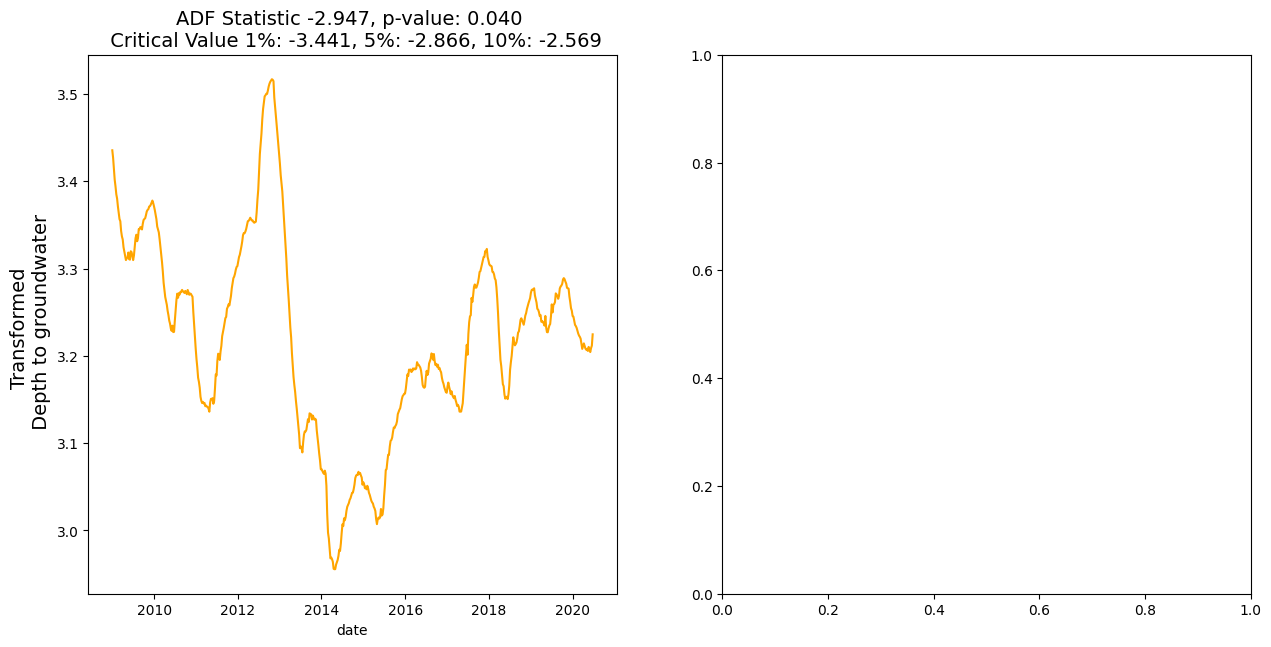

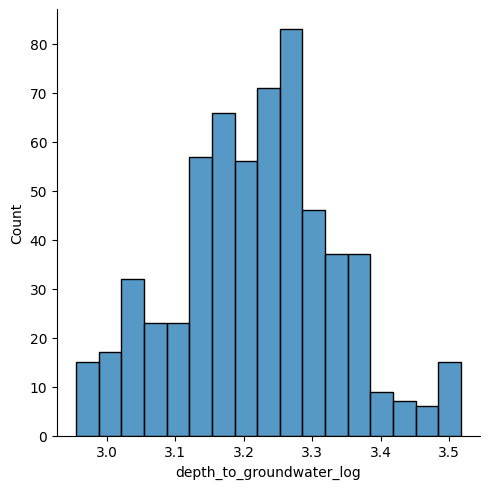

In [129]:
# Log Transform of absolute values 
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (15,7))
visualize_adfuller_results(df['depth_to_groundwater_log'].values, 'Transformed \n Depth to groundwater', axs[0])
sns.displot(df['depth_to_groundwater_log'], ax = axs[1])

### Differencing 

- First Order Differencing: linear Trends with $z_i = y_i - y_{i-1}$
- Second order differencing: quadratic trends with $z_i = (y_i - y{i-1}) - (y_{i-1} - y_{i-2}) - ... $

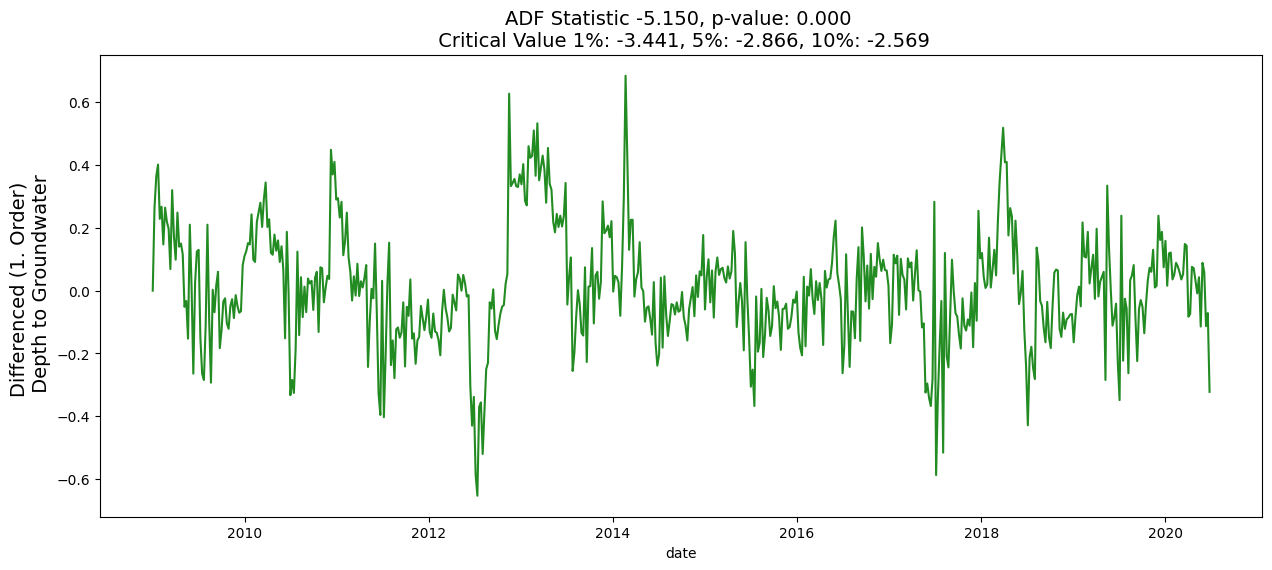

In [130]:
# First order Differencing 
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(15,6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', axs)

# Feature Engineering 

In [131]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year','week_of_year','quarter','season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


### Encoding Cyclical Features

<Axes: xlabel='date', ylabel='month'>

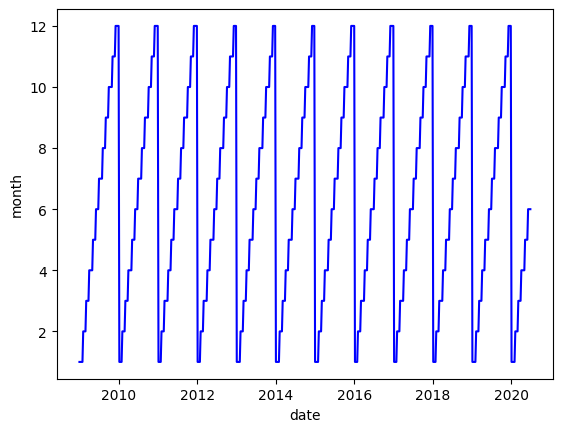

In [132]:
sns.lineplot(x=df['date'], y=df['month'], color='blue')

<Axes: xlabel='month_sin', ylabel='month_cos'>

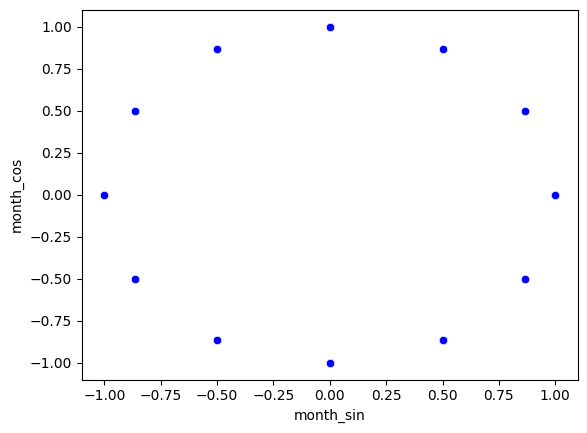

In [133]:
months = 12
df['month_sin'] = np.sin(2 * np.pi * df['month']/months)
df['month_cos'] = np.cos(2 * np.pi * df['month']/months)
sns.scatterplot(x=df.month_sin, y= df.month_cos, color = 'blue')

### Time Series Decomposition

Decomposing the time series into a combination of level, trend, seasonality, and noise components. 

- **Level:** The average value in the series.
- **Trend:** The increasing or decreasing value in the series.
- **Seasonality:** The repeating short-term cycle in the series.
- **Noise:** The random variation in the series.

Decomposing can provide a useful abstract model for understanding time series and for analysis and forecasting. 

All series have a level and noise. Trends and seasonality are optional 

Components can be additive or multiplicatively:

- **Additive:** $y(t) = Level + Trend + Seasonality + Noise$

- **Multiplicative:** $y(t) = Level * Trend * Seasonality * Noise$

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [135]:
core_cols = [
    'rainfall', 'temperature','drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

for col in core_cols:
    decomp = seasonal_decompose(df[col], period = 52, model = 'additive', extrapolate_trend = 'freq')
    df[f'{col}_trend'] = decomp.trend
    df[f'{col}_seasonal'] = decomp._seasonal

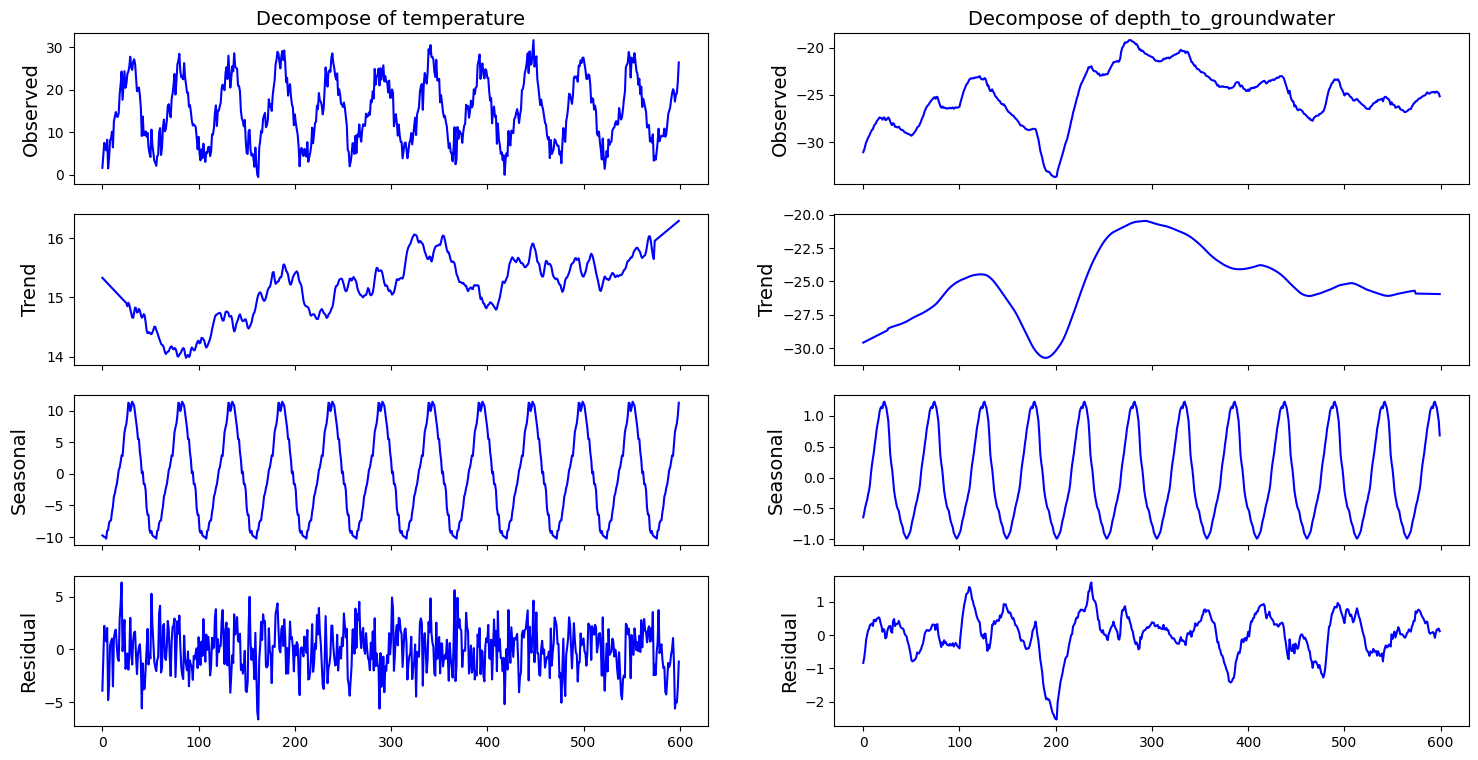

In [136]:
fig, axs = plt.subplots(4,2, sharex=True, figsize = (18,9))

for i , col in enumerate(['temperature', 'depth_to_groundwater' ]):
    res = seasonal_decompose(df[col], period = 52, model = 'additive', extrapolate_trend ='freq')
    
    axs[0,i].set_title(f"Decompose of {col}", fontsize = 14)
    res.observed.plot(ax=axs[0,i], legend = False, color = 'blue')
    axs[0,i].set_ylabel("Observed", fontsize = 14)
    
    res.trend.plot(ax=axs[1,i], legend = False, color = 'blue')
    axs[1,i].set_ylabel("Trend", fontsize = 14)
    
    res.seasonal.plot(ax=axs[2,i], legend = False, color = 'blue')
    axs[2,i].set_ylabel('Seasonal', fontsize = 14)
    
    res.resid.plot(ax=axs[3,i], legend = False, color = 'blue')
    axs[3,i].set_ylabel("Residual", fontsize = 14)

plt.show()

### Lag

Using a lag between features to see correlation with other features

In [137]:
weeks_m = 4

for col in core_cols:
    df[f'{col}_seasonal_shift_b_2m'] = df[f'{col}_seasonal'].shift(-2 * weeks_m)
    df[f'{col}_seasonal_shift_b_1m'] = df[f'{col}_seasonal'].shift(-1 * weeks_m)
    df[f'{col}_seasonal_shift_1m'] = df[f'{col}_seasonal'].shift(1 * weeks_m)
    df[f'{col}_seasonal_shift_2m'] = df[f'{col}_seasonal'].shift(2 * weeks_m)
    df[f'{col}_seasonal_shift_3m'] = df[f'{col}_seasonal'].shift(3 * weeks_m)

# Exploratory Data Analysis

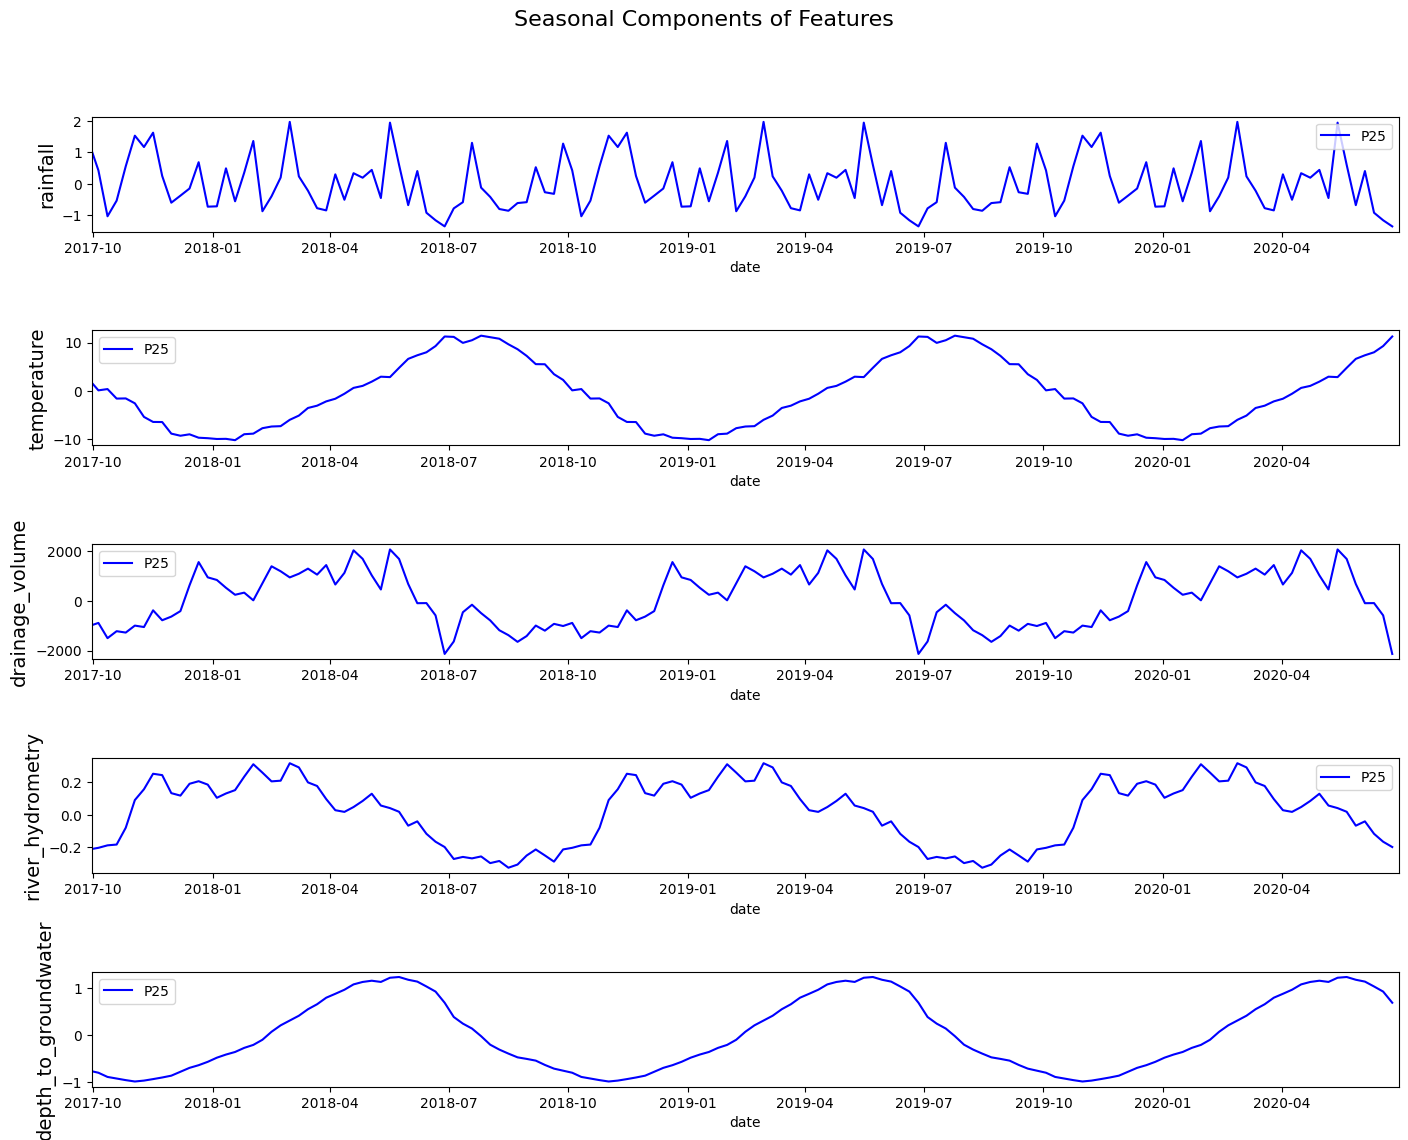

In [138]:
fig, axs = plt.subplots(5, 1, figsize=(15,12))
fig.suptitle("Seasonal Components of Features", fontsize = 16)

for i, col in enumerate(core_cols):
    sns.lineplot(x=df['date'], y=df[col+'_seasonal'], ax=axs[i], color = 'blue', label = 'P25')
    axs[i].set_ylabel(ylabel=col, fontsize = 14)
    axs[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout(pad = 4)
plt.show()

- **depth_to_groundwater:** reaches its maximum around June
- **Temperature:** Max around July or August
- **drainage_volume** min at July, max around may
- **river_hydrometry** max around Feb, March; min around August,September 

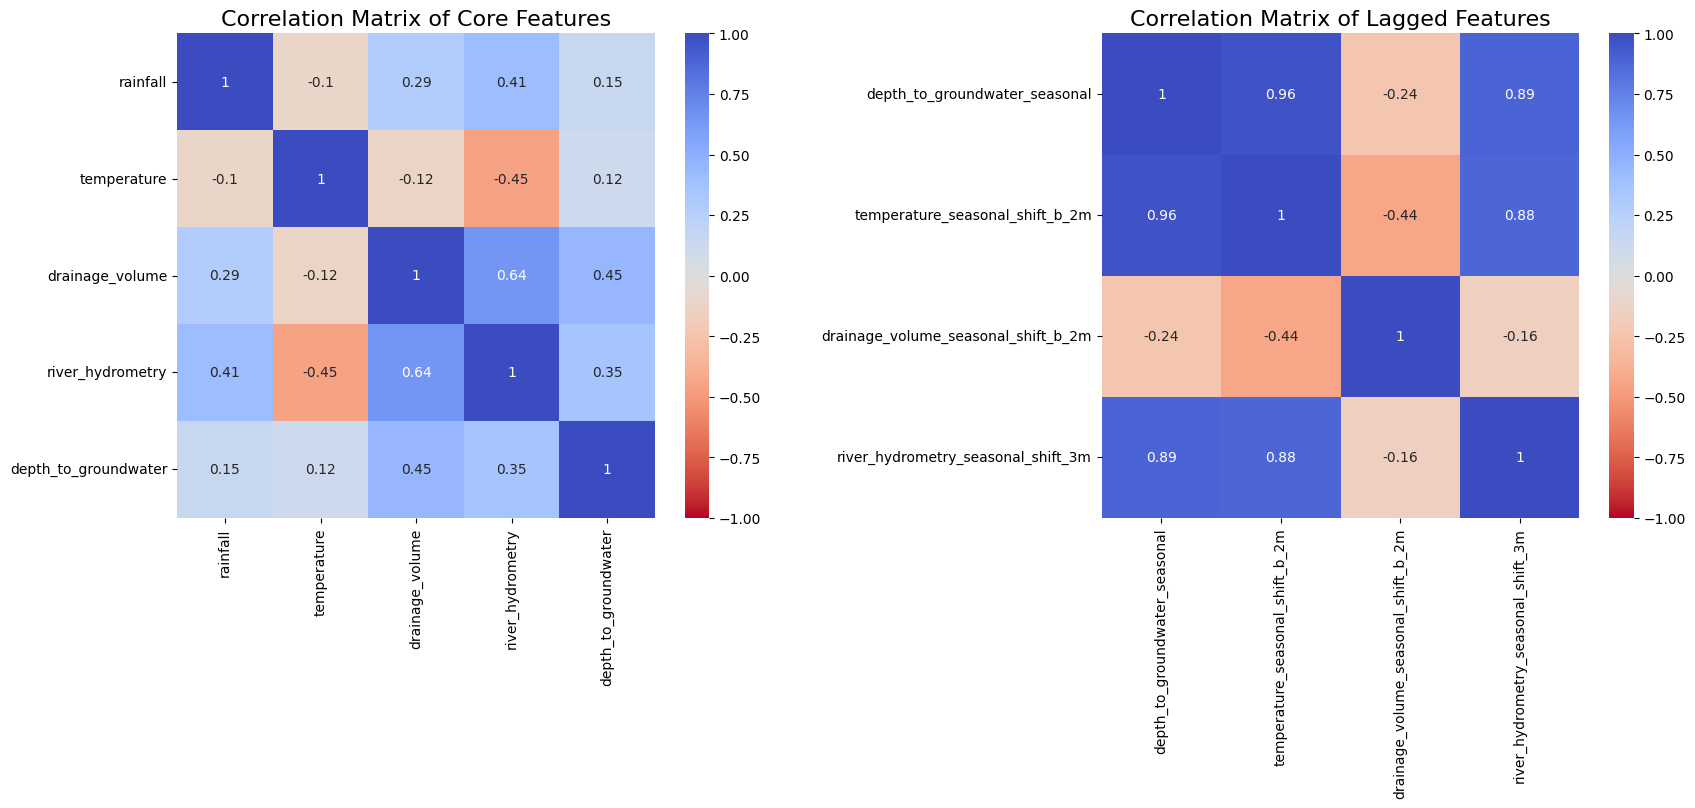

In [139]:
fig, axs = plt.subplots(1,2, figsize = (18,9))

corrmat = df[core_cols].corr()

sns.heatmap(corrmat, annot = True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=axs[0])
axs[0].set_title("Correlation Matrix of Core Features", fontsize = 16)

shifted_cols = [
    'depth_to_groundwater_seasonal',
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_b_2m',
    'river_hydrometry_seasonal_shift_3m',
]

corrmat2 = df[shifted_cols].corr()
sns.heatmap(corrmat2, annot = True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=axs[1])
axs[1].set_title("Correlation Matrix of Lagged Features", fontsize = 16)

plt.tight_layout(pad = 4)
plt.show()

Higher correlation between lagged features than the original features

### Autocorrelation Analysis

ACF and PACF plots: After stationarizing a time series by differencing the next steps are to determine whether Autoregression (AR) or Moving Average (MA) are needed to correct any autocorrelation remains in the differenced series. 

Looking at **Autocorrelation function (ACF)** and **Partial Autocorrelation function (PACF)** plots of differenced series, can tentatively identify the number of AR and/or MA terms that are needed. 

- **Autocorrelation Function (ACF):** P = Periods to lag for eg(if P = 3 then we will use 3 previous periods of time series in the autoregressive portion of the calculation). P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameters.

- **Partial Autocorrelation Function (PACF):** For ARIMA model the time series is transformed into stationary series (remove trends and seasonality) with differencing. D is the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.


AutoCorrelation plots help with detecting seasonality.

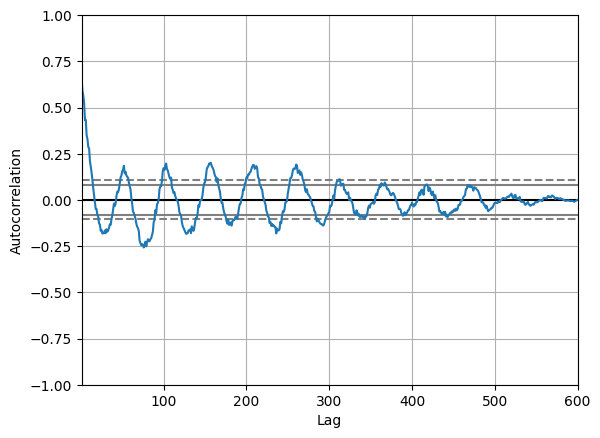

In [140]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

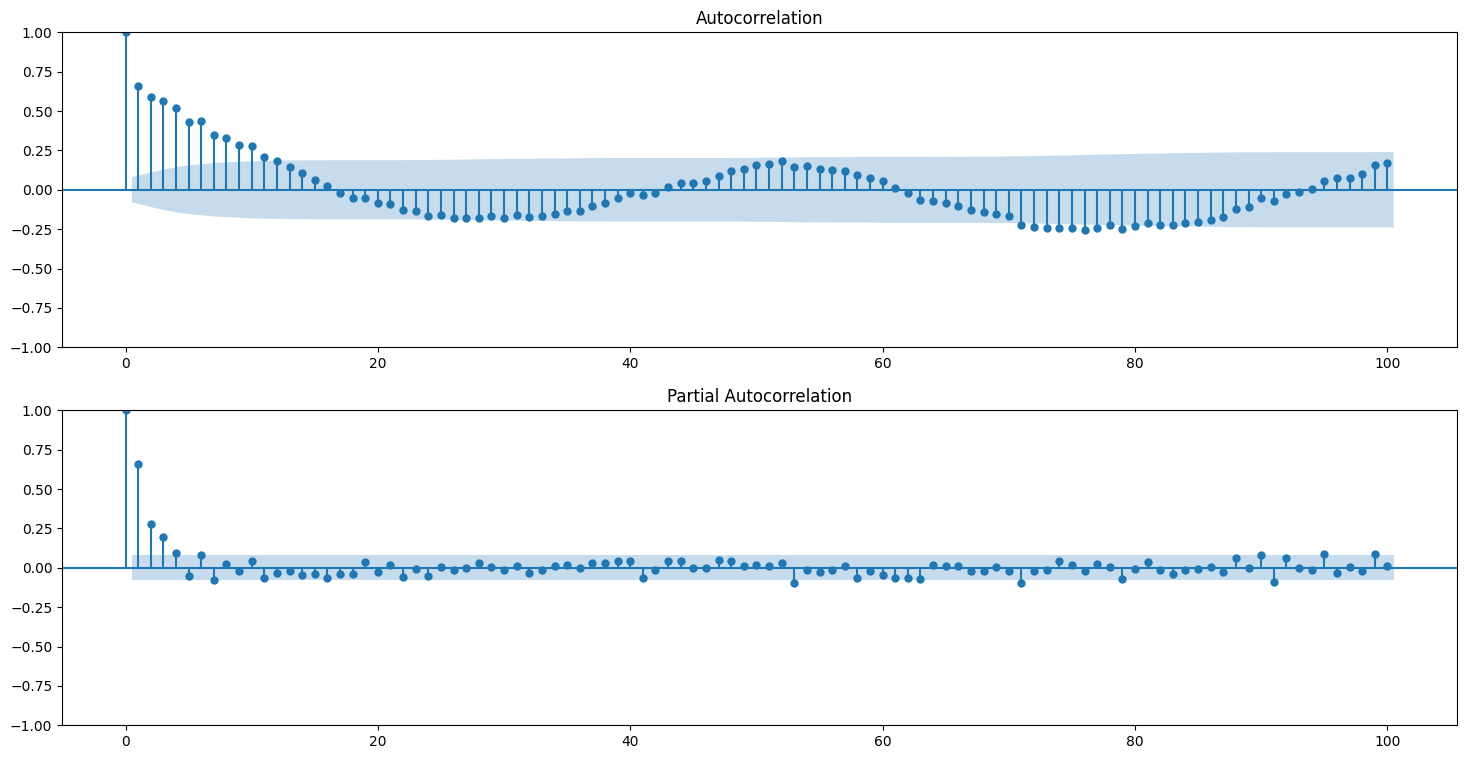

In [141]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axs = plt.subplots(2,1, figsize=(18,9))

plot_acf(df['depth_to_groundwater_diff_1'], lags = 100, ax= axs[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags = 100, ax = axs[1])

plt.show()

# Modeling



- **Univariate:** time series only has a single-dependent variable. 
- **Multivariate:** time series have a multiple time-dependent variable. 



**Cross Validation for Time Series**

In [142]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3
X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits = N_SPLITS)

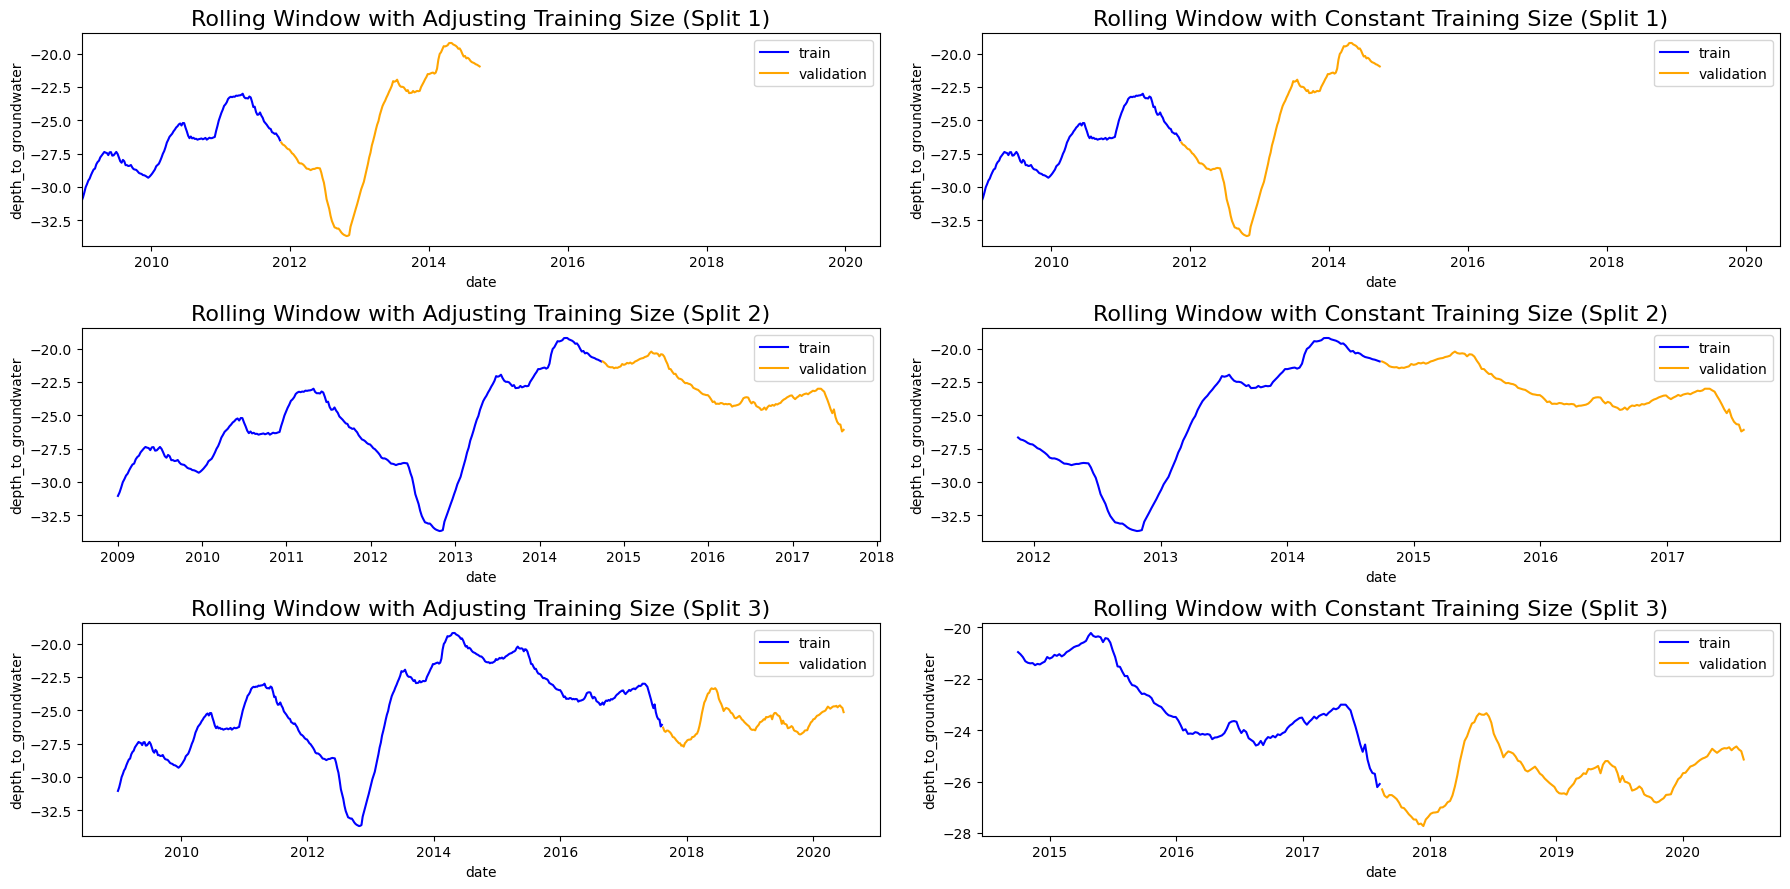

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [143]:
fig, axs = plt.subplots(N_SPLITS, 2, figsize = (18,9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    sns.lineplot(x=X_train,
                y=y_train,
                ax = axs[i,0],
                color = 'blue',
                label = 'train')
    sns.lineplot(x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
                y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
                ax=axs[i,1],
                color = 'blue',
                label = 'train')
    for j in range(2):
        sns.lineplot(x=X_valid, y=y_valid, ax=axs[i,j], color = 'orange', label='validation')
    axs[i,0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize = 16)
    axs[i,1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize = 16)
    
for i in range(N_SPLITS):
    axs[i,0].set_xlim([date(2009,1,1),date(2020,6,30)])
    axs[i,1].set_xlim([date(2009,1,1), date(2020,6,30)])
    
    plt.tight_layout()
    plt.show()

### Models for univariate time series

**Univariate Time Series:** only 1 variable is varying over time. 

In [144]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date','depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

X_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size,0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
X_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:,0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(X_valid))

510 90


### Prophet

open source library for univariate and multivariate time series forecasting developed by facebook. 

Prophet implements an additive time series forecasting models, and the implementation supports trends, seasonality, and holidays

In [145]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet

# Train the model
model = Prophet()
model.fit(train)

# Predict on valid set
y_pred = model.predict(X_valid)

# Calculate metrics 
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + f"RMSE: {score_rmse}")

20:39:23 - cmdstanpy - INFO - Chain [1] start processing
20:39:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.1754991866805253


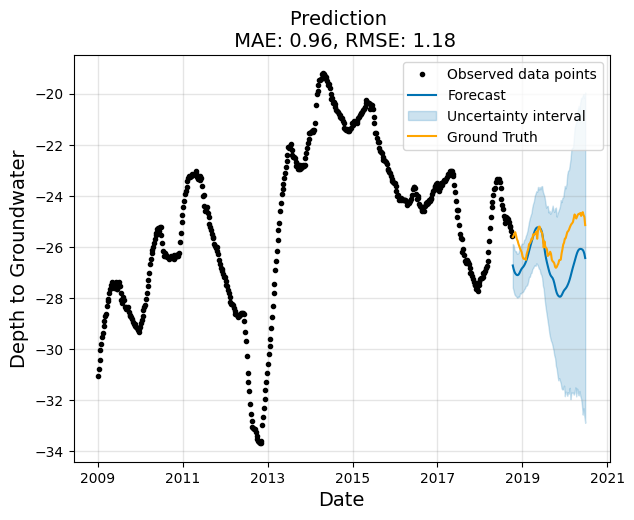

<Figure size 1500x700 with 0 Axes>

In [146]:
fig, ax = plt.subplots(1)
plt.figure(figsize = (15,7))

model.plot(y_pred, ax = ax)
sns.lineplot(x=X_valid['ds'],y=y_valid['y'], ax=ax, color = 'orange', label = 'Ground Truth' )

ax.set_title(f"Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}", fontsize = 14)
ax.set_xlabel(xlabel = 'Date', fontsize = 14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize = 14)

plt.show()

### ARIMA

Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data. The model assumes that the time series is stationary. It consists of 3 main parts:

- 

In [147]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [148]:
# Fit model
model = ARIMA(y_train, order = (1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(90)

# Calculate metrics 
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + f"RMSE: {score_rmse}")

RMSE: 1.402615843711107


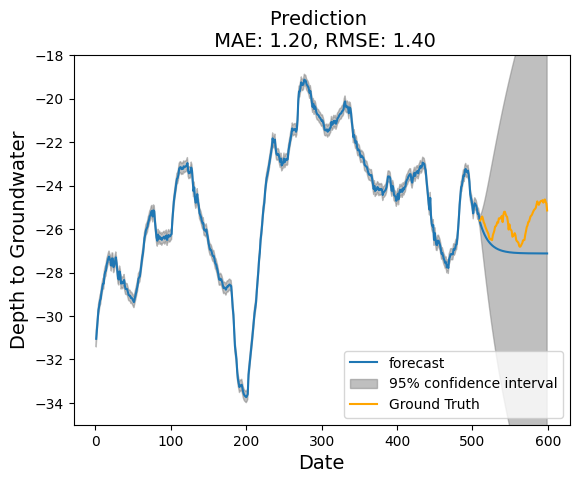

In [149]:
fig,ax = plt.subplots(1)

plot_predict(model_fit,1, 599, ax = ax)
sns.lineplot(x=X_valid.index, y = y_valid['y'], ax=ax, color = 'orange', label = 'Ground Truth')

ax.set_title(f"Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}", fontsize = 14)
ax.set_xlabel(xlabel='Date', fontsize = 14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize = 14)

ax.set_ylim(-35, -18)
plt.show()

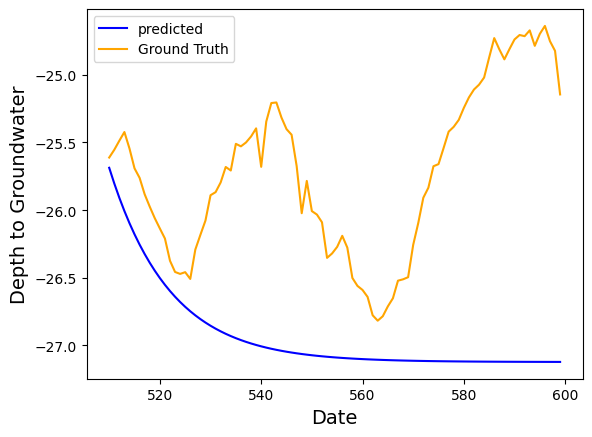

In [151]:
fig, ax = plt.subplots(1)

sns.lineplot(x=X_valid.index, y = y_pred, ax = ax, color = 'blue', label = 'predicted')
sns.lineplot(x=X_valid.index, y= y_valid['y'], ax = ax, color = 'orange', label = 'Ground Truth')

ax.set_xlabel(xlabel = 'Date', fontsize = 14)
ax.set_ylabel(ylabel = 'Depth to Groundwater', fontsize = 14)

plt.show()

### Auto-ARIMA

In [152]:
!pip install pmdarima

ERROR: Could not find a version that satisfies the requirement pmdarima (from versions: none)
ERROR: No matching distribution found for pmdarima


In [153]:
import pmdarima as pm

model = pm.auto_arima(y_train, start_p = 1, start_q = 1,
                     test = 'adf',
                     max_p= 3, max_q = 3,
                     m=1, d= None,
                     sesaonal = False, start_P=0,
                     D=0, trace = True, 
                     error_action = 'ignore',
                     suppress_warning = True,
                     stepwise=True)
print(model.summary())

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
model.plot_diagnostics(figsize = (16,8))
plt.show()

Interpreting results of the plot




### LSTM

using a multi-layered Long-Short-Term Memory LSTM Recurrent Neural Network to predict the last value of a sequence 

The following data processing needs to be done before utilizing the model 

- Create the dataset, ensure all data type is float. 
- Normalize the features. 
- Split into training and test sets. 
- convert an array of values into a dataset matrix. 
- Reshape into X=t and Y=t+1
- Reshape input to be 3D (num_samples, num_timesteps, num_features).


In [159]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
# Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1,0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [161]:
# Define the rolling Window 
look_back = 52

# split into train and test sets 
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, y = [], []
    
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        y.append(dataset[i,0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

#reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

print(len(X_train), len(X_test))

406 90


In [163]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model 
model.fit(X_train, y_train, batch_size = 1, epochs = 5, validation_data=(X_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 7s 8ms/step - loss: 0.0157 - val_loss: 0.0022
Epoch 2/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 6.3262e-04
Epoch 3/5
406/406 [==============================] - 2s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/5
406/406 [==============================] - 2s 5ms/step - loss: 0.0015 - val_loss: 6.9875e-04
Epoch 5/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 0.0026
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
               

In [183]:
# Predicting with the model 
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions 
train_predict = scaler.inverse_transform(train_predict)
#y_train = scaler.inverse_transform(y_train)

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print("RMSE: ", score_rmse)

3/3 [==============================] - 0s 4ms/step
RMSE:  0.7324166316970874


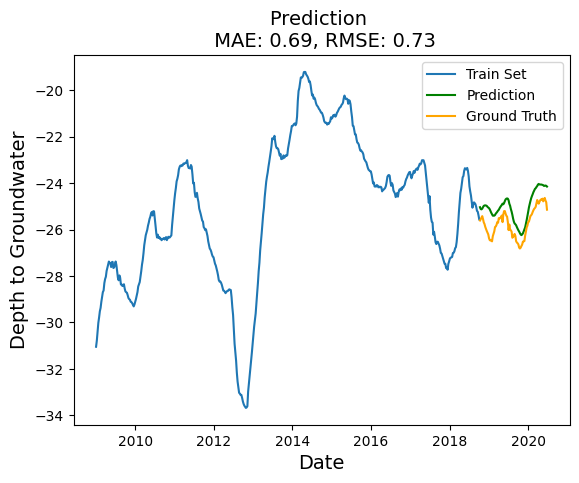

In [184]:
X_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
X_test_ticks = univariate_df.tail(test_size)['ds']

#plot the forecast
fig, ax = plt.subplots(1)

sns.lineplot(x=X_train_ticks, y= y_train, ax = ax, label = 'Train Set')
sns.lineplot(x=X_test_ticks, y = test_predict[:,0], ax = ax, color = 'green', label = 'Prediction')
sns.lineplot(x=X_test_ticks, y = y_test[0], ax = ax, color = 'orange', label = 'Ground Truth')

ax.set_title(f"Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}", fontsize = 14)
ax.set_xlabel(xlabel = 'Date', fontsize = 14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize = 14)

plt.show()

## Models for Multivariate Time Series

**Multivariate Time Series:** Multiple variables are varying overtime.

In [193]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry'
]

target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
X_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
X_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


### Multi-variate Prophet

In [195]:
# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit model to training 
model.fit(train)

# Predict on valid 
y_pred = model.predict(X_test)

# Calculate metrics 
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = np.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print("RMSE: ", score_rmse)

21:34:26 - cmdstanpy - INFO - Chain [1] start processing
21:34:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE:  0.9904421656840126


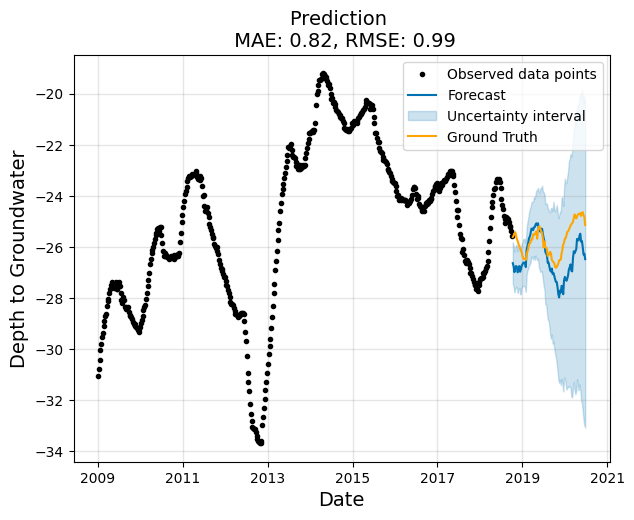

In [197]:
fig, ax = plt.subplots(1)

model.plot(y_pred, ax = ax)
sns.lineplot(x=X_valid['ds'], y=y_valid['y'], ax = ax, color = 'orange', label = 'Ground Truth')

ax.set_title(f"Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}", fontsize = 14)
ax.set_xlabel(xlabel='Date', fontsize = 14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize = 14)

plt.show()

# Conlusion

The Best results were from the Univariate LSTM that had a rolling window of 1 year (52 weeks) and the multi-variate Prophet model. 